In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import re
import string
from nltk.corpus import stopwords            #importing stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import math
import pickle



In [0]:

data = pd.read_csv('Reviews.csv')
print (data.head(2))
print(data.shape)

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
(568454, 10)


# #Data PreProcessing

In [0]:
#checking for Nan values in data. True indicates Nan values are present along the columns
data.isnull().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

In [0]:
# checking for Nan values along 'profilename' column
#data[data['ProfileName'].isnull()].head(2)

In [0]:
# checking for Nan values along 'summary' column
#data[data['Summary'].isnull()]

In [0]:
#Dropping Nan values
data = data.dropna()

In [0]:
#printing shape of data after dropping Nan values
print (data.shape)

(568411, 10)


In [0]:
#Review score should lie between 1 to 5
#Returns True if all the scores lie between 1 to 5(inclusive)
list1 = data['Score'].map(lambda x: True if x in [1,2,3,4,5] else False)
list1.all()

True

In [0]:
filtered_data = data.loc[data['Score']!=3].copy()
#print (filtered_data.head())
print (filtered_data.shape)

(525773, 10)


In [0]:
#mapping positive(>3) and negative(<3) reviews based on scores of the data.
pos_negative = filtered_data['Score'].map(lambda x: 'positive' if int (x) >3 else 'negative')
filtered_data['Score'] = pos_negative
print ('shape of filtered_data')
print (filtered_data.shape)
print (filtered_data.head(2))


shape of filtered_data
(525773, 10)
   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator     Score        Time                Summary  \
0                       1  positive  1303862400  Good Quality Dog Food   
1                       0  negative  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  


In [0]:
#arranging data with increasing productid
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort')

In [0]:
#finding the duplicates in our data
#If the same person gives for the same product at the same time we call it as suplicates
#sorted_data.loc[sorted_data.duplicated(["UserId","ProfileName","Time","Text"],keep = False),:]

In [0]:
#counting number of duplicates present in our data
sorted_data.duplicated(["UserId","ProfileName","Time","Text"]).sum()

161612

In [0]:
#dropping all duplicates keeping the first one
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace = False)
final.shape

(364161, 10)

In [0]:
#helpfulness numerator denotes number of people who found the review helpful
#helpfulness denominator denotes number of people who indicated whether or not the review helpful
#so, helpfulness numerator should be less than denominator
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#arranging data with increasing productid
final = final.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort')

In [0]:
#final shape of data after preprocessing
final.shape

(364159, 10)

In [0]:
final['Score'].value_counts()

positive    307054
negative     57105
Name: Score, dtype: int64

In [0]:
import pickle
with open("final.pkl", "wb") as f:
    pickle.dump(final, f)

In [0]:
with open("final.pkl", "rb") as f:
    final = pickle.load(f)

In [0]:
final_data1 = final.iloc[0:30000,:].copy()

In [0]:
final_data1.shape

(30000, 10)

In [0]:
final_data1['Score'].value_counts()

positive    26761
negative     3239
Name: Score, dtype: int64

In [0]:
import re
import string
from nltk.corpus import stopwords            #importing stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
not_words = re.findall(r'\w*n[\'|o]t',str (stop)) #finding NOT words in stop words
not_words.append('n\'t')
print (not_words)
stop_words = stop - set (not_words)  #removing  NOT words from stop words
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#|:]',r'',sentence)
    cleaned = re.sub(r'[.+|,|)|(|\|/]',r'',cleaned)
    return  cleaned
print('************************************')                 
print(stop_words)

["isn't", "shan't", "weren't", "mightn't", "wouldn't", "wasn't", 'not', "needn't", "haven't", "hasn't", "mustn't", "aren't", "shouldn't", "couldn't", "hadn't", "won't", "didn't", "don't", "doesn't", "n't"]
************************************
{'after', 'he', 'ourselves', 'his', 'that', "should've", 're', 'yours', 'doing', 'my', 'of', 'below', 'any', 'than', 'now', 'mightn', 'hers', 'or', 'm', 'once', 'the', 'themselves', 'when', 'ours', 'were', 'under', 'your', 'we', 'itself', 'do', 'with', 'no', 'him', 'where', 'll', 'needn', 'o', 'before', "you're", 'had', 'y', 'she', 'was', 'ain', 'their', 'which', 'you', 'because', 'our', 'each', 'until', 'same', 'if', 'herself', 'yourselves', 'both', 'has', "you'd", 'is', 'on', 'wasn', 'further', 'all', 'them', "that'll", 'at', 'off', 'yourself', 'about', 'haven', 'own', 'above', 'so', 'couldn', 'weren', 'a', 'himself', 'in', 'during', 'to', 'me', 'they', 'too', 'been', 'for', 'what', 'from', 'then', 'theirs', 'hasn', 'be', 'again', 'are', 'doesn'

In [0]:
str1=' '
final_string=[]
s=''
for sent in final_data1['Text'].values:
    filtered_sentence=[]    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop_words)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words for reviews
    final_string.append(str1)

In [0]:
final_data1['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
print (final_data1.shape)
final_data1.head(2) #below the processed review can be seen in the CleanedText Column 

(30000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


In [0]:
import pickle
final_data = pickle.load(open('drive/My Drive/Colab Notebooks/final_data.pkl','rb'))


In [0]:
final_data = final_data[0:50000]

In [16]:
final_data.shape

(50000, 13)

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(final_data['CleanedText'].values, final_data['Score'].values, 
                                                             test_size=0.3, random_state=42,shuffle=False)


In [0]:
model= CountVectorizer(dtype=float)
final_counts= model.fit_transform(X_train)

In [19]:
from sklearn.preprocessing import StandardScaler
standardizing  = StandardScaler(with_mean = False)
final_std_data = standardizing.fit_transform(final_counts)
final_std_data.shape

(35000, 22866)

In [20]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# creating odd list of K for KNN
myList = list(range(1,10,2))
# empty list that will hold cv scores
cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(knn, final_std_data, y_train, cv=3, scoring=auc)
    knn.fit(final_std_data,y_train)
    y_pred_proba = knn.predict_proba(final_std_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 


train scores
[1.0, 0.9540161519338851, 0.9331687586079103, 0.9206952520685976, 0.9116158473017916]
**************************************************
CV scores
[0.5576049660282564, 0.615972303410373, 0.6472113316474385, 0.6604867969009544, 0.6708296469975809]
CPU times: user 8min 11s, sys: 11.2 s, total: 8min 22s
Wall time: 8min 22s


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix
# creating odd list of K for KNN
myList = list(range(1,50))
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, final_counts.todense(), y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
error = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[error.index(min(error))]
print('\nThe optimal number of neighbors is {0} with {1} error.' .format(optimal_k,min(error)*100))

# plot misclassification error vs k 
plt.plot(myList, error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the percentage of misclassification error for each k value is : ",error*100)

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(final_std_data, y_train)

# predict the response
predictions = knn_optimal.predict(standardizing.transform(model.transform(X_test)))

# evaluate accuracy
acc = accuracy_score(y_test, predictions)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 8 is 89.822222%


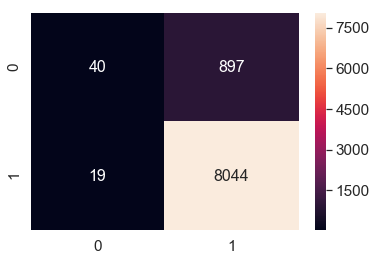

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

In [0]:
import pickle 
with open("final_data1.pkl", "rb") as f:
    final_data = pickle.load(f)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(final_data['CleanedText'].values, final_data['Score'].values, 
                                                             test_size=0.3, random_state=42,shuffle=False)


In [0]:
tf_idf_vector = TfidfVectorizer(ngram_range = (1,1))
tf_idf = tf_idf_vector.fit_transform(X_train)
tf_idf.shape

(21000, 22079)

In [0]:
standardizing  = StandardScaler(with_mean = False)
final_std_data = standardizing.fit_transform(tf_idf)
final_std_data.shape

(21000, 22079)


The optimal number of neighbors is 5 with 10.909520901900272error.


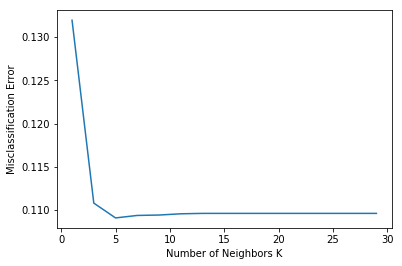

the misclassification error for each k value is :  [0.13195256833496372, 0.11080960818756558, 0.10909520901900271, 0.109380923326313, 0.10942854237933108, 0.10957141086815592, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488]


In [0]:
from sklearn.neighbors import KNeighborsClassifier
myList = list(range(1,30,2))
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, final_std_data, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
error = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[error.index(min(error))]
print('\nThe optimal number of neighbors is {0} with {1}error.' .format(optimal_k,min(error)*100))

# plot misclassification error vs k 
plt.plot(myList, error)

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", error)

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(final_std_data, y_train)

# predict the response
pred = knn_optimal.predict(standardizing.transform(tf_idf_vector.transform(X_test)))

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 5 is 89.600000%


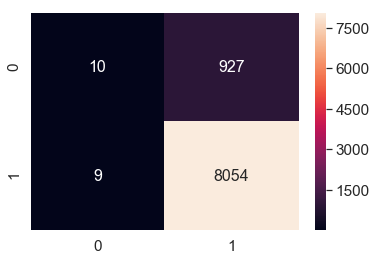

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,pred)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

C:\Users\Lenovo\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [0]:
from nltk.tokenize import word_tokenize
list_of_sent_train = [word_tokenize(sent.decode()) for sent in X_train]
list_of_sent_test = [word_tokenize(sent.decode()) for sent in X_test]
#list_of_sent[1]

In [0]:
import gensim
def w2v_vector(list_of_sent):
    #w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300)    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                #print (word)
                vec = model.wv[word]
                #print (vec)
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        if (cnt_words!=0):
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return (sent_vectors)

In [0]:
train_w2v_data = w2v_vector(list_of_sent_train)
test_w2v_data = w2v_vector(list_of_sent_test)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


21000
300
9000
300


In [0]:
avg_w2v_train_data1 = pd.DataFrame(data=train_w2v_data)
avg_w2v_test_data1 = pd.DataFrame(data=test_w2v_data)
#final_train_w2v_data.shape

In [0]:
import pickle
with open("avg_w2v_train_data1.pkl", "wb") as f:
    pickle.dump(avg_w2v_train_data1, f)
    
with open("avg_w2v_train_data1.pkl", "rb") as f:
    avg_w2v_train_data1 = pickle.load(f)

In [0]:
import pickle
with open("avg_w2v_test_data1.pkl", "wb") as f:
    pickle.dump(avg_w2v_test_data1, f)
    
with open("avg_w2v_test_data1.pkl", "rb") as f:
    avg_w2v_test_data1 = pickle.load(f)

In [0]:
import pickle
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
    
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

In [0]:
import pickle
with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)
    
with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

In [0]:
np.where(np.isnan(avg_w2v_train_data1))

(array([], dtype=int64), array([], dtype=int64))

In [0]:
standardizing  = StandardScaler(with_mean = False)
final_avg_w2v_std_data = standardizing.fit_transform(avg_w2v_train)
final_avg_w2v_std_data.shape

(21000, 300)

In [0]:
np.mean(final_avg_w2v_std_data)

-0.143648321617942

In [0]:
from pandas import DataFrame
f1=pd.DataFrame(data=final_avg_w2v_std_data)

In [0]:
type(f1)

pandas.core.frame.DataFrame


The optimal number of neighbors is 9 with 10.566706829988238 error.


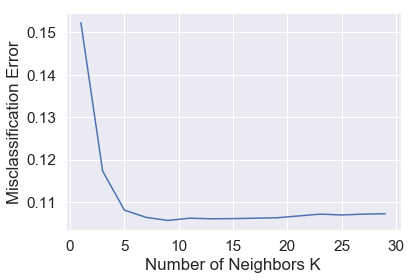

the misclassification error for each k value is :  [0.1522383516683009, 0.11728620718877636, 0.10809553780910885, 0.1063812520084394, 0.10566706829988237, 0.10619088918585651, 0.10604800936726111, 0.1060956057391419, 0.10619079848290336, 0.10628602523757302, 0.10671455133626395, 0.10714312278643123, 0.1069526579203266, 0.10714310011069306, 0.10723824750297817]


In [0]:
myList = list(range(1,30,2))
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, f1, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
error_w2v = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[error_w2v.index(min(error_w2v))]
print('\nThe optimal number of neighbors is {0} with {1} error.' .format(optimal_k,min(error_w2v)*100))

# plot misclassification error vs k 
plt.plot(myList, error_w2v)

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", error_w2v)

In [0]:
from pandas import DataFrame
w2v_test=pd.DataFrame(data=standardizing.transform(avg_w2v_test))

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(f1, y_train)

# predict the response
pred = knn_optimal.predict(w2v_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 9 is 89.877778%


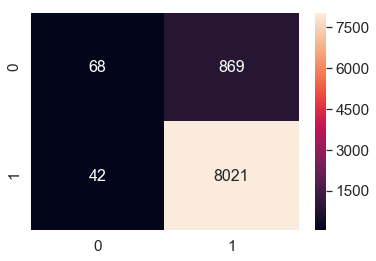

In [0]:
result = confusion_matrix(y_test,pred)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=8)

# fitting the model
knn_optimal.fit(f1, y_train)

# predict the response
pred = knn_optimal.predict(w2v_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (8, acc))


The accuracy of the knn classifier for k = 8 is 89.600000%


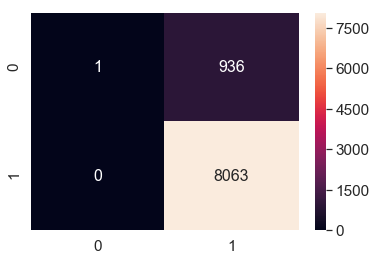

In [0]:
result = confusion_matrix(y_test,pred)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

In [0]:
tfidf_feat = tf_idf_vector.get_feature_names() # tfidf words/col-names

def tfidf_w2v_vector(list_of_sent):
    #w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300)    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(300) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                #print (word)
                vec = model.wv[word]
                #print (vec)
                tfidf = final_tf_idf[row, tfidf_feat.index(word)]
                sent_vec += (vec*tfidf)
                weight_sum += tfidf
                cnt_words += 1
            except:
                pass
        if(weight_sum!=0):
            sent_vec /= weight_sum
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return (sent_vectors)

In [0]:
train_tfidf_w2v_data = tfidf_w2v_vector(list_of_sent_train)
test_tfidf_w2v_data = tfidf_w2v_vector(list_of_sent_test)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


21000
300
9000
300


In [0]:
tfidf_w2v_train_data1 = pd.DataFrame(data=train_tfidf_w2v_data)
#final_train_w2v_data.shape
tfidf_w2v_test_data1 = pd.DataFrame(data=test_tfidf_w2v_data)

In [0]:
import pickle
with open("tfidf_w2v_train_data1.pkl", "wb") as f:
    pickle.dump(tfidf_w2v_train_data1, f)
    
with open("tfidf_w2v_train_data1.pkl", "rb") as f:
    tfidf_w2v_train_data1 = pickle.load(f)

In [0]:
import pickle
with open("tfidf_w2v_test_data1.pkl", "wb") as f:
    pickle.dump(tfidf_w2v_test_data1, f)
    
with open("tfidf_w2v_test_data1.pkl", "rb") as f:
    tfidf_w2v_test_data1 = pickle.load(f)

In [0]:
standardizing  = StandardScaler(with_mean = False)
tfidf_w2v_std_data = standardizing.fit_transform(tfidf_w2v_train)
tfidf_w2v_std_data.shape

(21000, 300)

In [0]:
from pandas import DataFrame
f2=pd.DataFrame(data=tfidf_w2v_std_data)


The optimal number of neighbors is 5 with 10.961902991577489 error.


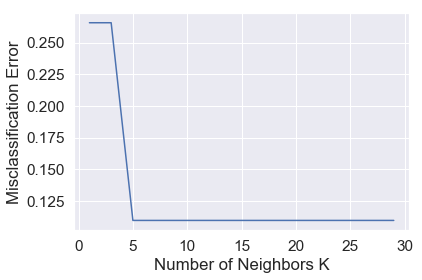

the misclassification error for each k value is :  [0.26572471903741257, 0.26572471903741257, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488, 0.10961902991577488]


In [0]:
myList = list(range(1,30,2))
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn,f2, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
error_tfidf_w2v = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[error_tfidf_w2v.index(min(error_tfidf_w2v))]
print('\nThe optimal number of neighbors is {0} with {1} error.'.format(optimal_k,min(error_tfidf_w2v)*100))

# plot misclassification error vs k 
plt.plot(myList, error_tfidf_w2v)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", error_tfidf_w2v)

In [0]:
from pandas import DataFrame
tfidf_w2v_test=pd.DataFrame(data=standardizing.transform(tfidf_w2v_test))

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(f2, y_train)

# predict the response
pred = knn_optimal.predict(tfidf_w2v_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 5 is 89.588889%


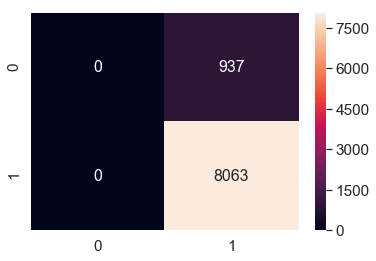

In [0]:
result = confusion_matrix(y_test,pred)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')


The optimal number of neighbors is 19 with 14.899889795693454 error.


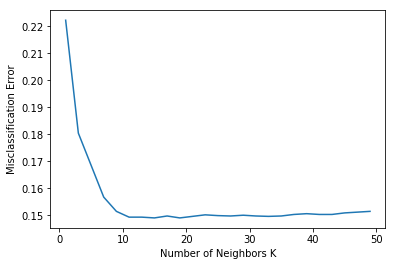

the misclassification error for each k value is :  [0.22228937056139775, 0.1804297431510793, 0.16857401866417798, 0.15671523557045164, 0.15142747463333017, 0.14928522536343358, 0.14928542973702863, 0.14899971428513115, 0.14971257229971024, 0.14899889795693455, 0.14957032652836322, 0.15014216384698165, 0.1498564495612673, 0.1497131842543119, 0.14999869474952288, 0.14971338804481515, 0.14957073410936983, 0.14971297871453382, 0.15028481603315247, 0.15057093906605645, 0.1502850204067473, 0.1502850198236556, 0.15085644956126742, 0.15114236822057658, 0.15142828687988585]


In [0]:
myList = list(range(1,50,2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, tfidf_w2v_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
error_tfidf_w2v1 = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[error_tfidf_w2v1.index(min(error_tfidf_w2v1))]
print('\nThe optimal number of neighbors is {0} with {1} error.'.format(optimal_k,min(error_tfidf_w2v1)*100))

# plot misclassification error vs k 
plt.plot(myList, error_tfidf_w2v1)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ",error_tfidf_w2v1)

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(tfidf_w2v_train, y_train)

# predict the response
pred = knn_optimal.predict(tfidf_w2v_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 19 is 82.266667%


In [0]:
tn,fp,fn,tp = confusion_matrix(y_test,pred).ravel()
print (tn,fp,fn,tp)

33 518 14 2435
